In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the movies dataset
<a class="anchor" id="load"></a>

In [3]:
DATA_PATH = './data'
MOVIE_PATH = os.path.join(DATA_PATH, 'movie.metadata.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'character.metadata.tsv')

In [4]:
m_cols = ["wikipedia_m_ID", "freebase_m_ID", "m_name", "m_release_date", "m_BO_revenue", "m_runtime", "m_languages", "m_countries", "m_genres"]
df_movies=pd.read_csv(MOVIE_PATH, sep='\t', names=m_cols, converters={'m_languages': literal_eval, 'm_countries': literal_eval, 'm_genres': literal_eval})

# 2. Quick look at the data
<a class="anchor" id="quicklook"></a>

In [5]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikipedia_m_ID  81741 non-null  int64  
 1   freebase_m_ID   81741 non-null  object 
 2   m_name          81741 non-null  object 
 3   m_release_date  74839 non-null  object 
 4   m_BO_revenue    8401 non-null   float64
 5   m_runtime       61291 non-null  float64
 6   m_languages     81741 non-null  object 
 7   m_countries     81741 non-null  object 
 8   m_genres        81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [6]:
df_movies.sample(4)

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
28961,789953,/m/03cd3z,The Chechahcos,1924-05-12,NaN,87.0,{},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/07s9rl0': 'Dra..."
43464,1196030,/m/04gf4t,Car Wash,1976,NaN,97.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01q03': 'Cult', '/m/01z4y': 'Comedy'}"
59579,28645571,/m/0cz9r8d,Toxic Zombies,1980,NaN,89.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/0jb4p32': 'Zombie Film', '/m/03npn': 'Hor..."
61446,24222823,/m/07k3zdk,Hellish Mad Rush,NaN,NaN,NaN,{},{},{}


# 3. Data preprocessing
<a class="anchor" id="preprocessing"></a>

#### Columns conversion

In [7]:
#Movie release dates are parsed as datetime.
df_movies['m_release_date']=pd.to_datetime(df_movies['m_release_date'], errors = 'coerce')

#### Movie freebase ID

In [8]:
#A sample of movies is taken to get their freebase ID. The average is then done on how much of them had a valid movie freebase ID.
tot = []
k_size = 8
n = 100
for k in range(k_size):
    rd_elements = random.sample(df_movies['freebase_m_ID'].apply(lambda x: x.split('/')[2]).to_list(), n)
    url='%28%3'
    for x in rd_elements:
        url += 'Ftitle%20%3D%20%22%2Fm%2F' + x + '%22%20%7C%7C%20%3'
    query = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3Ftitle%20WHERE%20%7B%20%0A%20%20VALUES%20%3Fmovietype%20%7B%20wd%3AQ11424%7D%0A%20%20%3Fs%20p%3AP31%2Fps%3AP31%20%3Fmovietype.%0A%20%20%3Fs%20wdt%3AP646%20%3Ftitle.%0A%20%20FILTER{}%22%29%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D'.format(url[:-17])
    response = requests.get(query)
    response = response.json()['results']['bindings']
    tot.append(len(response))

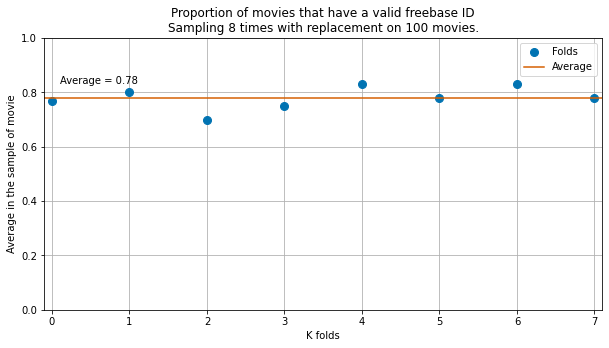

There is around 78.00% of the movies that have an active wikipedia freebase ID.


In [9]:
ratio = [x/n for x in tot]
avg_ratio = sum(ratio)/k_size
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, k_size-1, k_size).astype(int), ratio, marker='o', linewidth=0, markersize=8, color=BLUE, label='Folds')
plt.xticks(np.linspace(0, k_size-1, k_size).astype(int))
plt.plot(np.linspace(-1, k_size, k_size).astype(int), [avg_ratio]*k_size, color=RED, label='Average')
plt.xlim(- 0.1, k_size -1 + 0.1)
plt.ylim(0, 1)
plt.xlabel("K folds")
plt.ylabel("Average in the sample of movie")
plt.grid()
plt.text(0.1, avg_ratio + 0.05, "Average = {:.2f}".format(avg_ratio))
plt.legend()
plt.title("Proportion of movies that have a valid freebase ID\nSampling {} times with replacement on {} movies.".format(k_size, n))
plt.show()
print("There is around {:.2f}% of the movies that have an active wikipedia freebase ID.".format(avg_ratio*100))

#### Critical values

In [10]:
#Number of movies with critical values.
nb_critical_values = df_movies[~df_movies.astype(bool).all(axis=1)].shape[0]
print("There are {} rows with critical values. These are values such as: empty dictionaries, 0, nan, etc.".format(nb_critical_values))

There are 17949 rows with critical values. These are values such as: empty dictionaries, 0, nan, etc.


#### Duplicated rows

In [11]:
df_temp = df_movies.copy()
df_temp['m_languages'] = df_temp['m_languages'].apply(lambda x: str(list(x.values())))
df_temp['m_countries'] = df_temp['m_countries'].apply(lambda x: str(list(x.values())))
df_temp['m_genres'] = df_temp['m_genres'].apply(lambda x: str(list(x.values())))
nb_movie_duplicated_rows = df_temp.duplicated().sum()
print("There are {} duplicated rows in the movie dataset.".format(nb_movie_duplicated_rows))

There are 0 duplicated rows in the movie dataset.


#### Duplicated movies

In [12]:
df_movies[df_movies.duplicated(subset=['m_name', 'm_release_date'], keep=False)].sort_values('m_name').head(4)

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
64872,24604084,/m/080cdj1,A,1998-01-01,NaN,136.0,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},"{'/m/0gw5n2f': 'Japanese Movies', '/m/03q4nz':..."
66267,23488527,/m/06w8mcl,A,1998-01-01,NaN,NaN,{'/m/09bnf': 'Kannada Language'},{'/m/03rk0': 'India'},{'/m/02l7c8': 'Romance Film'}
38544,33545449,/m/0hgrdzf,A Sister to Assist 'Er,NaT,NaN,59.0,{},{},{'/m/05p553': 'Comedy film'}
74307,33545395,/m/0hgrll0,A Sister to Assist 'Er,NaT,NaN,64.0,{},{},{'/m/05p553': 'Comedy film'}


In [13]:
#Number of duplicated movies.
nb_movies_duplicated = df_movies[df_movies.duplicated(subset=['m_name', 'm_release_date'], keep=False)]['wikipedia_m_ID'].count()
print("There are {} duplicated movies.".format(nb_movies_duplicated))

There are 196 duplicated movies.


#### Movie release date

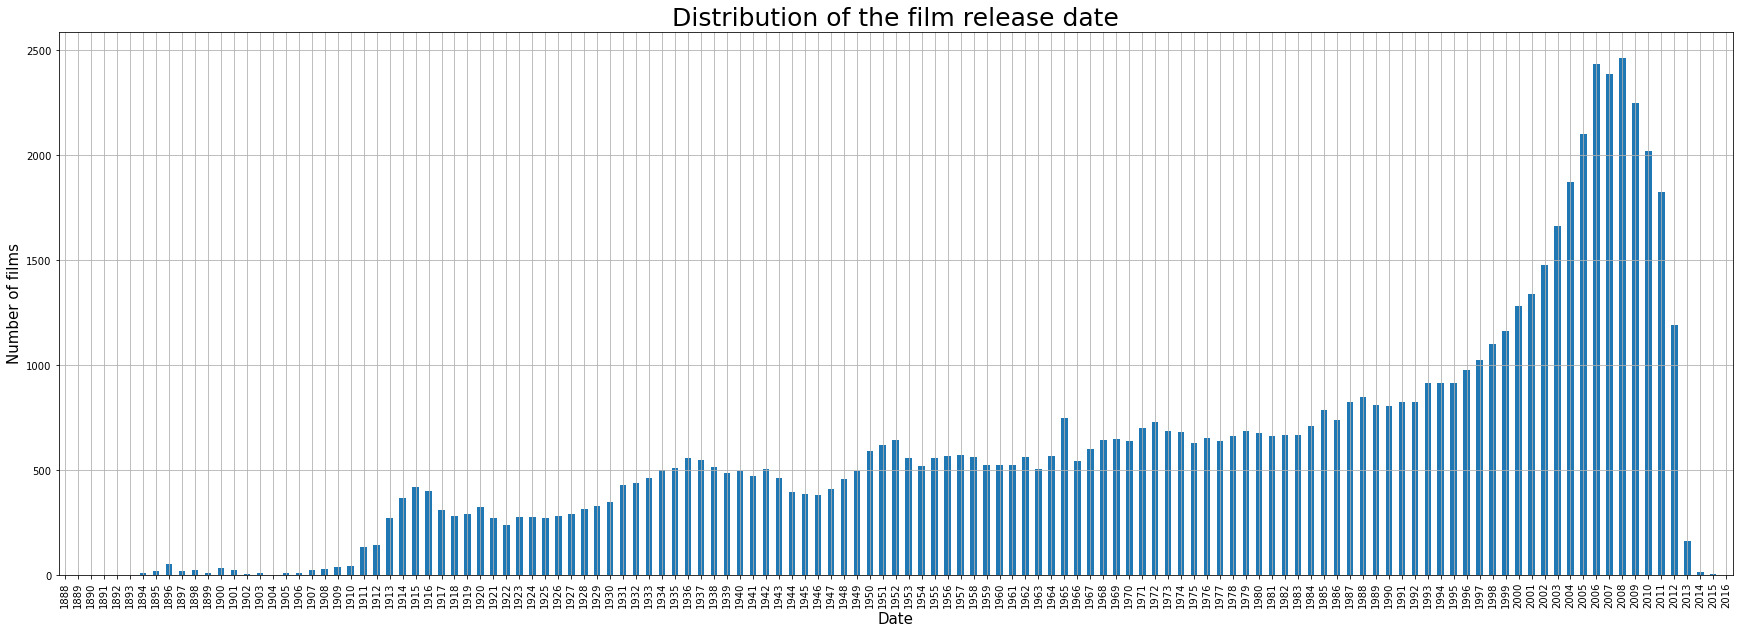

In [14]:
#Movie release date quick overview
df_movies['m_release_date'].dropna().dt.year.sort_values().value_counts(sort=False).plot(kind='bar', figsize=(30,10))
plt.grid()
plt.title('Distribution of the film release date', fontsize=25)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of films', fontsize=15)
plt.show()

In [15]:
#Quick look at the movies after 2013.
df_movies[df_movies['m_release_date'].dt.year > 2013].sort_values('m_release_date', ascending=False).head()

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
34022,23124260,/m/064mmw7,Jeepers Creepers 4,2016-06-08,NaN,NaN,{},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/03npn': 'Horror'}"
30275,27554912,/m/0c03gcc,Kung Fu Panda 3,2016-03-18,NaN,NaN,{},{},{}
64862,3139382,/m/08tyfg,Battle Angel,2016-01-01,NaN,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
51429,25813358,/m/0gmbk1g,Avatar 2,2015-01-01,NaN,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06n90': 'Science Fiction', '/m/02kdv5l': ..."
53855,32416903,/m/0gys9tc,Total Dhamaal,2015-01-01,NaN,138.0,{'/m/03k50': 'Hindi Language'},{},{'/m/05p553': 'Comedy film'}


In [16]:
nb_movies_after_2013 = df_movies[df_movies['m_release_date'].dt.year > 2013].shape[0]
print("There are {} movies released after 2013. It can be seen that several movies have a wrong date of release (e.g Avatar 2).".format(nb_movies_after_2013))

There are 24 movies released after 2013. It can be seen that several movies have a wrong date of release (e.g Avatar 2).


#### Movie runtime

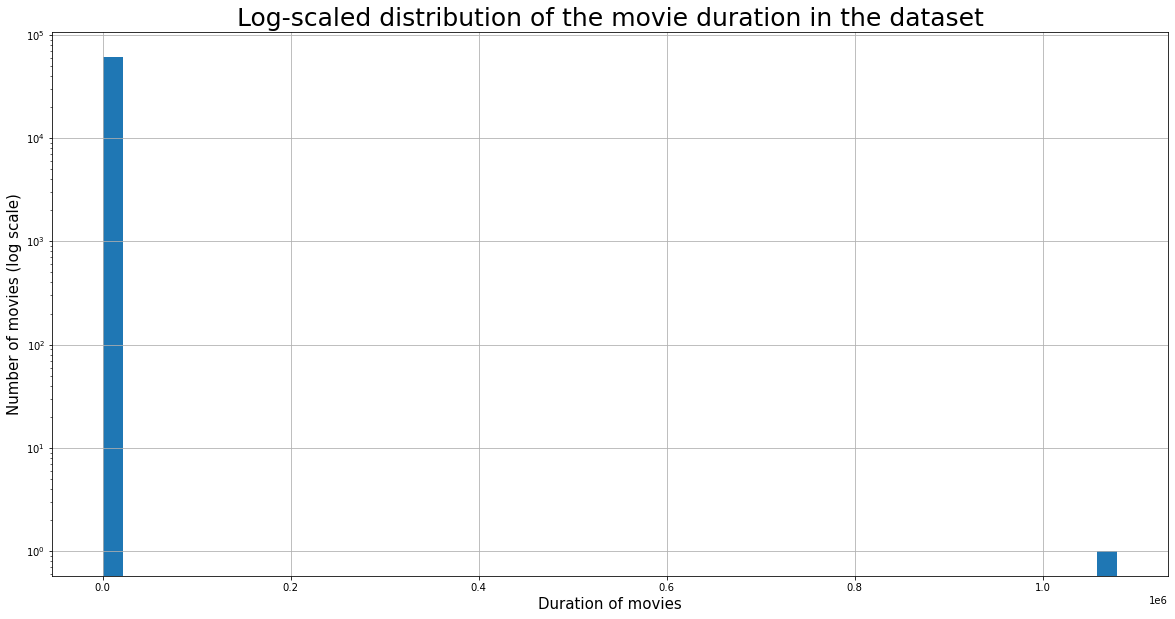

In [17]:
plt.figure(figsize=(20,10))
df_movies.m_runtime.hist(bins=50)
plt.yscale('log')
plt.ylabel('Number of movies (log scale)', fontsize=15)
plt.xlabel('Duration of movies', fontsize=15)
plt.title("Log-scaled distribution of the movie duration in the dataset", fontsize=25)
plt.show()

In [18]:
nb_movies_duration_inf_1 = df_movies[(df_movies['m_runtime']>= 1500)]['wikipedia_m_ID'].count()
nb_movies_duration_supp_1500 = df_movies[(df_movies['m_runtime']<= 1)]['wikipedia_m_ID'].count()
print("There are {} movies which a runtime > 1500 and {} movies with a runtime < 1.".format(nb_movies_duration_inf_1, nb_movies_duration_supp_1500))

There are 14 movies which a runtime > 1500 and 107 movies with a runtime < 1.


One can see that there are some outliers in the runtime. It might be due to the time conversion. As the runtime input is supposed to be in minutes, freebase ID will be queried using wikidata to know whether the runtime is the correct one.

The movie database contains following errors:
- **Critical values**: There are values such as empty dictionaries, 0, False in the rows. For practicity, they'll be all replaced by np.nan values.
- **Duplicated movies**: There are movies that can be considered identical (same movie name and same release date). Some of them are duplicated. They'll be safely removed by keeping the first one as they represent the same movie.
- **Movie release date**: There are some outliers in the movie release date. This mainly concerns movies after 2013. It is due to the creation date of the dataset: 2013. It means all the movies after 2013 are probable dates of release rather than effective ones. Those will be queried using freebase movie ID and changed when possible (as it might be earlier). After this operation, the movies after 2013 will be dropped as it was too recent regarding the dataset creation. This is also a reason why there is too few movies after 2013.
- **Movie runtime**: There are some outliers in the movie runtime. Movie runtime is supposed to be in minutes. However, there is one movie that would last 60 days. In the other way, there are many films that last less than a minute. It is probable that all those cases are due to wrong conversions (i.e duration expressed in seconds or in hours). Those will be queried using freebase movie ID and changed when possible. If the movie does not exist using freebase, the runtime will be kept. But when studying runtime, it will be important to remember those edgecases.

#### Cleaning

In [19]:
df_movies=df_movies.where(df_movies.astype(bool),np.nan).drop_duplicates(subset=['m_name', 'm_release_date'], keep='first')

In [20]:
feature_wiki_ID={
    "runtime": 'AP2047',
    "pubdate":'AP577'
}

def get_freebase_feature_movie(row, value, op, n_lim, feature):
    ops = {
    '>=' : operator.ge,
    '<=' : operator.le,
    '>' : operator.gt,
    '<' : operator.lt,
    }
    op = ops[op]
        
    if feature == 'pubdate':
        val_to_compare=value.year
    else:
        val_to_compare = value
    
    if op(val_to_compare, n_lim):
        id_m = str(row['freebase_m_ID'].split('/')[2])
        query = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3FsLabel%20%3Fp%20%20%3Fo%20%3FoLabel%20%3F{}%20WHERE%20%7B%0A%20%3Fs%20wdt%3AP646%20%22%2Fm%2F{}%22.%0A%20%3Fs%20wdt%3{}%20%3F{}.%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D'.format(feature, id_m, feature_wiki_ID[feature], feature)
        response_json = requests.get(query).json()['results']['bindings']
        if len(response_json):
            
            if feature == 'runtime':
                new_value = float(response_json[0][feature]['value'])
                if new_value!=value:
                    time.sleep(2)
                    print("{} movie had a {} of {:.2f}. However, using freebase ID, {}={}min.".format(row['m_name'], feature,
                                                                                               value, feature, 
                                                                                               new_value))
                    value = new_value
            elif feature=='pubdate':
                new_value = (response_json[0][feature]['value'])
                new_value=new_value.replace("Z", "")
                new_value = datetime.strptime(new_value,'%Y-%m-%dT%H:%M:%S')
                if new_value.year!=value.year:
                    print("{} movie had a {} of {}. However, using freebase ID, {}={}.".format(row['m_name'], feature,
                                                                                               value.date(), feature, 
                                                                                               new_value.date()))
                    value = new_value
            
    return value

In [21]:
time.sleep(10)
df_movies['m_release_date'] = df_movies[['m_release_date', 'freebase_m_ID', 'm_name']].apply(lambda row: get_freebase_feature_movie(row, row['m_release_date'], '>=', 2015, 'pubdate'), axis=1)

Avatar 2 movie had a pubdate of 2015-01-01. However, using freebase ID, pubdate=2022-12-14.
Total Dhamaal movie had a pubdate of 2015-01-01. However, using freebase ID, pubdate=2018-12-07.
Battle Angel movie had a pubdate of 2016-01-01. However, using freebase ID, pubdate=2019-02-06.


In [22]:
df_movies = df_movies[df_movies.m_release_date.dt.year < 2013]

In [23]:
time.sleep(10)
df_movies['m_runtime'] = df_movies[['m_runtime', 'freebase_m_ID', 'm_name']].apply(lambda row: get_freebase_feature_movie(row, row['m_runtime'], '>', 1500, 'runtime'), axis=1)
df_movies['m_runtime'] = df_movies[['m_runtime', 'freebase_m_ID', 'm_name']].apply(lambda row: get_freebase_feature_movie(row, row['m_runtime'], '<', 1, 'runtime'), axis=1)

Zero Tolerance movie had a runtime of 1079281.00. However, using freebase ID, runtime=88.0min.
Dhool Ka Phool movie had a runtime of 1533.00. However, using freebase ID, runtime=153.0min.
Cinématon movie had a runtime of 9360.00. However, using freebase ID, runtime=11828.0min.
Dil Ne Phir Yaad Kiya movie had a runtime of 1966.00. However, using freebase ID, runtime=148.0min.
As Seen Through a Telescope movie had a runtime of 0.70. However, using freebase ID, runtime=55.0min.
Men Boxing movie had a runtime of 0.08. However, using freebase ID, runtime=5.0min.
Fred Ott's Sneeze movie had a runtime of 0.08. However, using freebase ID, runtime=4.0min.
Sick Kitten movie had a runtime of 0.57. However, using freebase ID, runtime=34.0min.
The X-Rays movie had a runtime of 0.73. However, using freebase ID, runtime=44.0min.
Blacksmith Scene movie had a runtime of 0.57. However, using freebase ID, runtime=34.0min.
L'Arroseur Arrosé movie had a runtime of 0.82. However, using freebase ID, runtime=

# 4 Dataset preparation
<a class="anchor" id="datapreparation"></a>

3 columns of the movie dataset will be split: movie languages, movie country of production and movie genres. They will be split in two columns: freebase ID in the first, and value in the other.

In [24]:
def split_feature(row, feature, flag):
    """
    Splits list-like columns into key for freebase_ID and value for the value.

    :param row: Row to apply the split
    :param feature: Column to split
    :param flag: Takes the value if True, the key if False
    :return: The value or the key of row[feature]
    """
    if isinstance(row[feature], float):
        return np.nan
    elif flag:
        return list(row[feature].values())
    else:
        return row[feature].keys()

In [25]:
features = ['m_languages', 'm_countries', 'm_genres']
_freebase_ID = '_freebase_ID'
for i, feature in enumerate(features):
    df_movies[feature+_freebase_ID] = df_movies.apply(lambda row: split_feature(row, feature, 0), axis=1)
    df_movies[feature] = df_movies.apply(lambda row: split_feature(row, feature, 1), axis=1)

In [26]:
df_movies.drop(['m_languages_freebase_ID', 'm_countries_freebase_ID', 'm_genres_freebase_ID'], axis=1, inplace=True)

In [27]:
df_countries_m = df_movies.explode('m_countries').dropna(subset='m_countries')
nb_unique_countries = df_countries_m['m_countries'].nunique()
print("There are {} different countries present in the dataset.".format(nb_unique_countries))

There are 146 different countries present in the dataset.


In [28]:
df_movies_USA = df_countries_m[df_countries_m['m_countries']=='United States of America']

#### Movie genres

In [29]:
df_genres_m_USA = df_movies_USA.explode('m_genres')

In [30]:
nb_genres_USA = df_genres_m_USA['m_genres'].nunique()
print("There are {} different genre in american movies.".format(nb_genres_USA))

There are 341 different genre in american movies.


####  PCA on movie genre

In [31]:
def one_hot_encoding(df, col):
    y = pd.get_dummies(df[col])
    return y, y.columns

In [32]:
one_hot, genres_one_hot_labels = one_hot_encoding(df_genres_m_USA, 'm_genres')
df_USA_genres_one_hot = pd.concat([df_genres_m_USA, one_hot], axis=1)
df_USA_genres_one_hot = df_USA_genres_one_hot.groupby('wikipedia_m_ID')[genres_one_hot_labels].sum()

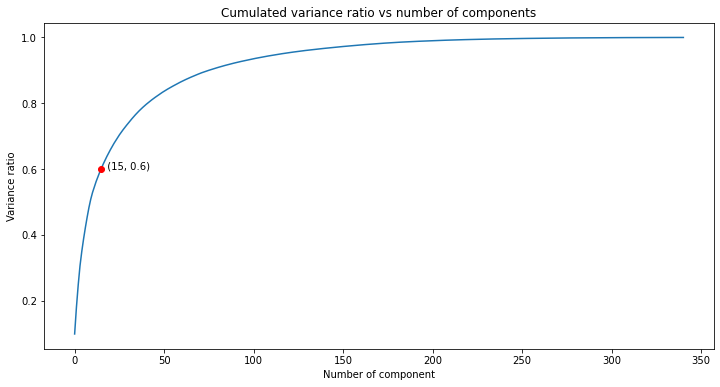

In [33]:
n=nb_genres_USA
scaler = MinMaxScaler()
X_features = scaler.fit_transform(df_USA_genres_one_hot)
pca = PCA(n)
pca.fit(X_features)
pca_variance = pca.explained_variance_
pca_variance_ratio = pca.explained_variance_ratio_

csum = np.cumsum(pca_variance_ratio)
plt.figure(figsize=(12, 6))
plt.plot(csum)
plt.plot(15, 0.6, marker='o', color='red') 
plt.ylabel('Variance ratio')
plt.xlabel('Number of component')
plt.title('Cumulated variance ratio vs number of components')
plt.text(15, 0.6, '  ({}, {})'.format(15, 0.6))
plt.show()

The PCA shows that we can significantly reduce the number of genres. The following code is a work-in-progress to make analysis on genres and grasp the similarities and differences between genres.

It was decided to keep 15 features in order to get 60% of the cumulated variance.

In [34]:
n=15
scaler = StandardScaler()
X_features = scaler.fit_transform(df_USA_genres_one_hot)
pca = PCA(n)
pca.fit_transform(X_features)
pca_variance = pca.explained_variance_

In [35]:
# number of components
n_pcs= pca.components_.shape[0]

best_four_important = []
most_important_names = []
n_best = 4
initial_feature_names = genres_one_hot_labels
for i in range(n_pcs):
    elts = np.argsort((pca.components_[i]))[::-1][:n_best]
    best_four_important.append(elts)
    most_important_names.append([initial_feature_names[elts[i]] for i in range(n_best)])

In [36]:
new_space = pca.transform(df_USA_genres_one_hot.values)
new_space = new_space.argmax(axis=1)

df_USA_genres_one_hot['m_genre_PCA'] = new_space
df_USA_genres_one_hot['m_genre_PCA'] = df_USA_genres_one_hot['m_genre_PCA'].apply(lambda x: ", ".join(most_important_names[x]))

In [37]:
df_movies_USA_genre_PCA = df_movies_USA.merge(df_USA_genres_one_hot[['m_genre_PCA']], left_on='wikipedia_m_ID', right_on='wikipedia_m_ID')

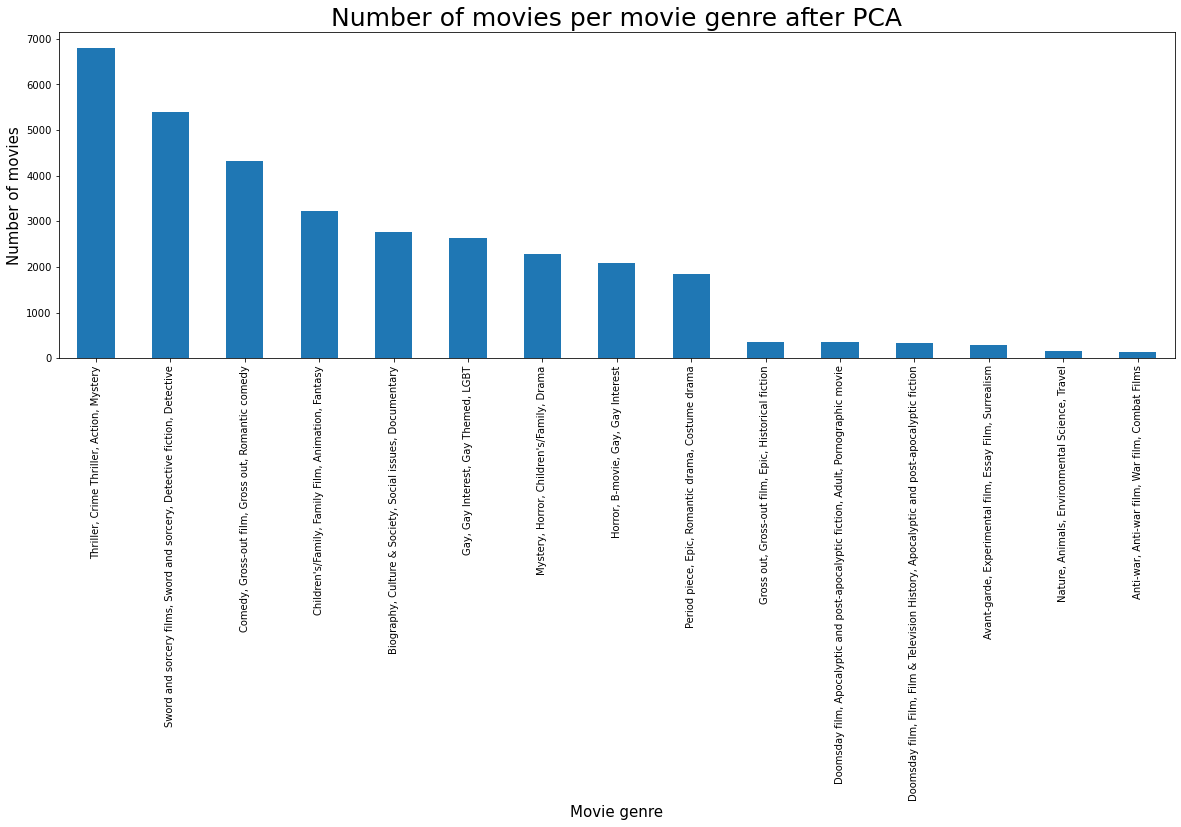

In [38]:
plt.figure(figsize=(20,6))
df_movies_USA_genre_PCA['m_genre_PCA'].value_counts().plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per movie genre after PCA', fontsize = 25)
plt.xlabel('Movie genre', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

# Output clean CSV

In [40]:
OUTPUT_FILE_MOVIES = 'american_movies_cleaned.tsv'
OUTPUT_PATH = os.path.join(DATA_PATH, OUTPUT_FILE_MOVIES)
df_movies_USA_genre_PCA.to_csv(OUTPUT_PATH, sep="\t", index=False)